# Data Modeling without accounting for multicolinearity
Trying a baseline model with various features from the feature Engineering phase. 
- Data has issues with multicolinearity - This will see how the data does without removing features. 
- Oversampling techniques (not undersampling because the dataset is already small) - Finalizing the dataset to use. 
- Baseline model will be with Logistic regression
- Can try SVM and other models. 

The data can be found here: https://www.kaggle.com/yasserh/breast-cancer-dataset

Documentation can be found here: https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(diagnostic)

You can also find the github repo here: https://github.com/brianl2/BrCancer_LHL_final



In [1]:
# import modules
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
# load dataframes:
brca = pd.read_csv('data/averaged_brca.csv')
outliers = pd.read_csv('data/averaged_outliersrm.csv')

## Dataset 1 : Original features with outliers. 

In [133]:
# Lets work with outliers first and only the original features, to get a baseline for these set of features. 
ogbrca = brca.iloc[:, 0:31]
ogbrca.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
#Defining functions: 

# oversampling to fix imbalance we observed previously.
sm = SMOTE(random_state=42)

def oversample(df, df2 = None):
    '''function for oversampling with SMOTE'''
    X = df.loc[:, df.columns != 'diagnosis']
    if 'diagnosis' in df.columns:
        y = df.loc[:, df.columns == 'diagnosis']
    else: 
        y = df2['diagnosis']
    print(f'before resample: {y.shape}')
    xres, yres = sm.fit_resample(X, y)
    print(f'after resample: {yres.shape}')
    # Show the imbalance fixed 
    colors = sns.color_palette('pastel')[0:5]
    data = yres.value_counts()
    labels =['Resampled Benign Tumors','Resampled Malignant Tumors']
    #create pie chart
    plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
    plt.show()
    return xres,yres

# Function to prep the data for modeling
def prep_data(df, df2=None):
    '''Function for Oversampling, Splitting data, and reshaping into numpy array (x,)'''
    # oversample the data
    x,y = oversample(df, df2)
    # Split the data (80:20) ratio because we don't have much data
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42) 
    #Scale / normalize the data
    scale = StandardScaler()
    X_train = scale.fit_transform(X_train)
    X_test = scale.transform(X_test)
    #Reshape y for modeling
    y_train = np.array(y_train).ravel()
    y_test = np.array(y_test).ravel()
    return X_train, X_test, y_train, y_test

before resample: (569, 1)
after resample: (714, 1)


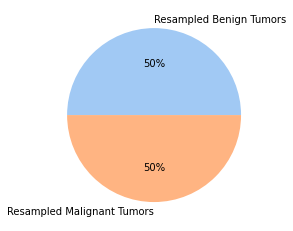

In [142]:
# Oversample the data & prep it
X_train, X_test, y_train, y_test = prep_data(ogbrca)

Modeling baseline for Dataset 1. 

In [143]:
# Lets just try a logistic regression first and see what we get
LR = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = LR.predict(X_test)

print(classification_report(y_test, y_pred, target_names=["Malignant","Benign"]))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

   Malignant       0.99      0.99      0.99        74
      Benign       0.99      0.99      0.99        69

    accuracy                           0.99       143
   macro avg       0.99      0.99      0.99       143
weighted avg       0.99      0.99      0.99       143

Confusion Matrix:
[[73  1]
 [ 1 68]]


In [144]:
LR.score(X_test,y_test)

0.986013986013986

## Dataset 2 Original Dataset with outliers, with no Oversampling

In [138]:
# Perhaps there is dataleakage due to SMOTE oversampling? Maybe just try the original dataset. 
# Splitting X and Y
X = ogbrca.loc[:, ogbrca.columns != 'diagnosis']
y = ogbrca.loc[:, ogbrca.columns == 'diagnosis']
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42) 
#Scale the data
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)
#Reshape y 
y_train = np.array(y_train).ravel()
y_test = np.array(y_test).ravel()

In [139]:
# Modeling With Logistic regression 
LR = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = LR.predict(X_test)

print(classification_report(y_test, y_pred, target_names=["Malignant","Benign"]))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

   Malignant       0.98      0.95      0.96        43
      Benign       0.97      0.99      0.98        71

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

Confusion Matrix:
[[41  2]
 [ 1 70]]


In [140]:
LR.score(X_test,y_test)

0.9736842105263158

## Dataset 3 Outliers present (only new features designed) 
In the Feature engineering, I took the average of mean and worst features to make a new column - effectively reducing 20 features to 10. 
try: 
- With new features
- With new features + SE 

In [165]:
brca['diagnosis']

0      0
1      0
2      0
3      0
4      0
      ..
564    0
565    0
566    0
567    0
568    1
Name: diagnosis, Length: 569, dtype: int64

In [193]:
# Outliers and only new features, Try oversampling
og2brca = brca.iloc[:, 31:41] 
og2brca.head()

,radius,texture,perimeter,area,smoothness,compactness,concavity,concave,symmetry,fractal_dimension
0,21.685,13.855,153.700,1510.0,0.14030,0.47160,0.50600,0.206250,0.35100,0.098805
1,22.780,20.590,145.850,1641.0,0.10427,0.13262,0.16425,0.128085,0.22810,0.072845
2,21.630,23.390,141.250,1456.0,0.12700,0.29220,0.32390,0.185450,0.28410,0.073785
3,13.165,23.440,88.225,476.9,0.17615,0.57510,0.46415,0.181350,0.46175,0.135220
4,21.415,15.505,143.650,1436.0,0.11885,0.16890,0.29900,0.133400,0.20865,0.067805


before resample: (569,)
after resample: (714,)


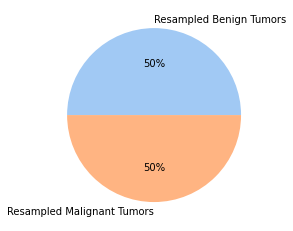

In [183]:
feat_x, test_x, feat_y, test_y = prep_data(og2brca, brca)

In [191]:
# Logistic regression model for Just the new features. 
LR = LogisticRegression(random_state=0).fit(feat_x, feat_y)
pred_y = LR.predict(test_x)

print(classification_report(test_y, pred_y, target_names=["Malignant","Benign"]))
print("Confusion Matrix:")
print(confusion_matrix(test_y, pred_y))
print(LR.score(test_x,test_y))

              precision    recall  f1-score   support

   Malignant       0.99      0.99      0.99        74
      Benign       0.99      0.99      0.99        69

    accuracy                           0.99       143
   macro avg       0.99      0.99      0.99       143
weighted avg       0.99      0.99      0.99       143

Confusion Matrix:
[[73  1]
 [ 1 68]]
0.986013986013986


In [205]:
# Trying with features designed + SE 
og3brca = brca.iloc[:, 11:21] 
oggbrca = pd.merge(og3brca, og2brca, left_index=True, right_index=True)
oggbrca.head()

,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius,texture,perimeter,area,smoothness,compactness,concavity,concave,symmetry,fractal_dimension
0,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,21.685,13.855,153.700,1510.0,0.14030,0.47160,0.50600,0.206250,0.35100,0.098805
1,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,22.780,20.590,145.850,1641.0,0.10427,0.13262,0.16425,0.128085,0.22810,0.072845
2,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,21.630,23.390,141.250,1456.0,0.12700,0.29220,0.32390,0.185450,0.28410,0.073785
3,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,13.165,23.440,88.225,476.9,0.17615,0.57510,0.46415,0.181350,0.46175,0.135220
4,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,21.415,15.505,143.650,1436.0,0.11885,0.16890,0.29900,0.133400,0.20865,0.067805


before resample: (569,)
after resample: (714,)


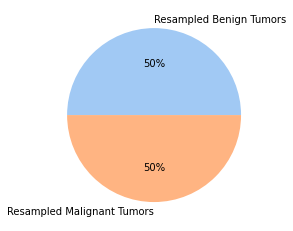

              precision    recall  f1-score   support

   Malignant       1.00      0.97      0.99        74
      Benign       0.97      1.00      0.99        69

    accuracy                           0.99       143
   macro avg       0.99      0.99      0.99       143
weighted avg       0.99      0.99      0.99       143

Confusion Matrix:
[[72  2]
 [ 0 69]]
0.986013986013986


In [206]:
# Logistic regression model for new features + SE
feat_x2, test_x2, feat_y2, test_y2 = prep_data(oggbrca, brca)
LRse = LogisticRegression(random_state=0).fit(feat_x2, feat_y2)
pred_y2 = LRse.predict(test_x2)

print(classification_report(test_y2, pred_y2, target_names=["Malignant","Benign"]))
print("Confusion Matrix:")
print(confusion_matrix(test_y2, pred_y2))
print(LRse.score(test_x2,test_y2))

### Using the designed features + SE, I got a lower recall, but higher precision. Accuracy is the same. 
- 98.6% is the same as the logistic regression we got for just the regular features
- Doesn't seem like the features we designed made any difference.
- next step, Try all features, We will keep oversampling with the function, as that gives higher accuracy for the model. (Also fixes imbalances) 
## Dataset 4: Original Dataset + Designed features scaled -> No Outliers removed

In [8]:
brca.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius,texture,perimeter,area,smoothness,compactness,concavity,concave,symmetry,fractal_dimension
0,0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,21.685,13.855,153.700,1510.0,0.14030,0.47160,0.50600,0.206250,0.35100,0.098805
1,0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,22.780,20.590,145.850,1641.0,0.10427,0.13262,0.16425,0.128085,0.22810,0.072845
2,0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,21.630,23.390,141.250,1456.0,0.12700,0.29220,0.32390,0.185450,0.28410,0.073785
3,0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,13.165,23.440,88.225,476.9,0.17615,0.57510,0.46415,0.181350,0.46175,0.135220
4,0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,21.415,15.505,143.650,1436.0,0.11885,0.16890,0.29900,0.133400,0.20865,0.067805


before resample: (569, 1)
after resample: (714, 1)


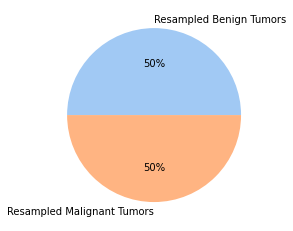

In [9]:
# Original Dataset + Designed features scaled -> No Outliers removed
X_train, X_test, y_train, y_test = prep_data(brca)

In [11]:
# Logistic regression of All features outliers not removed. 
LR = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = LR.predict(X_test)

print(classification_report(y_test, y_pred, target_names=["Malignant","Benign"]))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
LR.score(X_test,y_test)

              precision    recall  f1-score   support

   Malignant       0.97      0.99      0.98        74
      Benign       0.99      0.97      0.98        69

    accuracy                           0.98       143
   macro avg       0.98      0.98      0.98       143
weighted avg       0.98      0.98      0.98       143

Confusion Matrix:
[[73  1]
 [ 2 67]]


0.9790209790209791

It seems that with all features, the accuracy is slightly lower, but the recall is a bit higher (might be more beneficial in this case) 
- Still not as good as the baseline. (May be better to just use original features or reduced down to just the designed features) 

# Continuing with different models & Dataset 5 Outliers removed 
- Baseline established at 98.6% with No outliers removed, and Logistic regression, scaled with standardscaler. 
- Try different different features engineered 

In [115]:
# import modules for modeling. 
from sklearn import svm
sklearn.naive_bayes import GaussianNB #The data looks pretty normal. 
from sklearn.linear_model import SGDClassifier


In [4]:
# Lets work without outliers and the original features, to get a baseline.
outbrca = outliers.iloc[:, 0:31]
outbrca.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
1,0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
2,0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.2,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
3,0,12.45,15.70,82.57,477.1,0.12780,0.17000,0.1578,0.08089,0.2087,...,15.47,23.75,103.4,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440
4,0,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.1127,0.07400,0.1794,...,22.88,27.66,153.2,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368


before resample: (502, 1)
after resample: (674, 1)


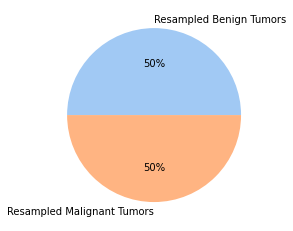

In [5]:
# To prep the data for modeling.
X_train2, X_test2, y_train2 , y_test2 = prep_data(outbrca)

In [146]:
# Modeling with default Logistic regression 
LR2 = LogisticRegression(random_state=0).fit(X_train2, y_train2)
y_pred2 = LR2.predict(X_test2)

print(classification_report(y_test2, y_pred2, target_names=["Malignant","Benign"]))
print("Confusion Matrix:")
print(confusion_matrix(y_test2, y_pred2))
print(LR2.score(X_test2,y_test2))

              precision    recall  f1-score   support

   Malignant       0.99      0.94      0.96        71
      Benign       0.94      0.98      0.96        64

    accuracy                           0.96       135
   macro avg       0.96      0.96      0.96       135
weighted avg       0.96      0.96      0.96       135

Confusion Matrix:
[[67  4]
 [ 1 63]]
0.9629629629629629


In [147]:
# modeling with default SVC 
clf = svm.SVC().fit(X_train2, y_train2)
y_pred2 = clf.predict(X_test2)
print(classification_report(y_test2, y_pred2, target_names=["Malignant","Benign"]))
print("Confusion Matrix:")
print(confusion_matrix(y_test2, y_pred2))
print(clf.score(X_test2,y_test2))

              precision    recall  f1-score   support

   Malignant       0.97      0.93      0.95        71
      Benign       0.93      0.97      0.95        64

    accuracy                           0.95       135
   macro avg       0.95      0.95      0.95       135
weighted avg       0.95      0.95      0.95       135

Confusion Matrix:
[[66  5]
 [ 2 62]]
0.9481481481481482


In [148]:
# modeling with default Linear SVC 
clf = svm.LinearSVC().fit(X_train2, y_train2)
y_pred2 = clf.predict(X_test2)
print(classification_report(y_test2, y_pred2, target_names=["Malignant","Benign"]))
print("Confusion Matrix:")
print(confusion_matrix(y_test2, y_pred2))
print(clf.score(X_test2,y_test2))

              precision    recall  f1-score   support

   Malignant       1.00      0.94      0.97        71
      Benign       0.94      1.00      0.97        64

    accuracy                           0.97       135
   macro avg       0.97      0.97      0.97       135
weighted avg       0.97      0.97      0.97       135

Confusion Matrix:
[[67  4]
 [ 0 64]]
0.9703703703703703


## Summary:
Overall, it seems that using the original data without accounting for multicollinearity still works great.
- You get a really good model with good scores overall 

According to online sources, classification predicting models don't get affected by multicollinearity as harshly, which seems to be the case here.
- For the next Notebook, we will try modeling 